# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Time Series Modeling with Facebook Prophet 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How is crime distributed in 78745?</a></li>
><li><a href="#q5"> 5. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q6"> 6. How is crime distributed across council districts?
><li><a href="#q7"> 7. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import warnings
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
%matplotlib inline
plt.style.use("classic")

In [2]:
df = pd.read_csv("crime_reports.csv")

In [3]:
display(df.head())
display(df.tail())

Incident Number     Highest Offense Description  Highest Offense Code  \
0      20183000009              DATING DISTURBANCE                  2400   
1      20141381413              FAMILY DISTURBANCE                  3400   
2      20081002040  CRASH/FAIL STOP AND RENDER AID                  3604   
3      20161971680                             DWI                  2100   
4      20135029070                PROTECTIVE ORDER                  3829   

  Family Violence      Occurred Date Time Occurred Date  Occurred Time  \
0               N  10/27/2018 12:03:00 AM    10/27/2018            3.0   
1               N  05/18/2014 07:09:00 PM    05/18/2014         1909.0   
2               N  04/09/2008 07:04:00 PM    04/09/2008         1904.0   
3               N  07/15/2016 10:15:00 PM    07/15/2016         2215.0   
4               N  06/28/2013 12:15:00 PM    06/28/2013         1215.0   

         Report Date Time Report Date  Report Time  \
0  10/27/2018 12:28:00 AM  10/27/2018         28.0   
1  05/18/2014 07:09:00 PM  05/18/2014       1909.0   
2  04/09/2008 09:08:00 PM  04/09/2008       2108.0   
3  07/16/2016 12:22:00 AM  07/16/2016         22.0   
4  06/28/2013 12:15:00 PM  06/28/2013       1215.0   

                  Location Type                  Address  Zip Code  \
0         PARKING LOTS / GARAGE       2201 MONTOPLOIS DR       NaN   
1              RESIDENCE / HOME  12836 BUENOS ARIES PKWY       NaN   
2  STREETS / HWY / ROAD / ALLEY  2500 BLOCK OF GUADALUPE       NaN   
3  STREETS / HWY / ROAD / ALLEY      6000 BLK OF BOLM RD       NaN   
4              RESIDENCE / HOME        COHISE COUNTY  AZ       NaN   

   Council District APD Sector APD District  PRA  Census Tract  \
0               NaN        NaN          NaN  NaN           NaN   
1               NaN        NaN          NaN  NaN           NaN   
2               NaN        NaN          NaN  NaN           NaN   
3               NaN        NaN          NaN  NaN           NaN   
4               NaN        NaN          NaN  NaN           NaN   

  Clearance Status Clearance Date UCR Category Category Description  \
0                N     10/31/2018          NaN                  NaN   
1                N     05/26/2014          NaN                  NaN   
2                N     12/16/2008          NaN                  NaN   
3                C     01/03/2018          NaN                  NaN   
4                N     06/28/2013          NaN                  NaN   

   X-coordinate  Y-coordinate  Latitude  Longitude Location  
0           NaN           NaN       NaN        NaN      NaN  
1           NaN           NaN       NaN        NaN      NaN  
2           NaN           NaN       NaN        NaN      NaN  
3           NaN           NaN       NaN        NaN      NaN  
4           NaN           NaN       NaN        NaN      NaN

Incident Number  Highest Offense Description  Highest Offense Code  \
2285146       2020951013         THEFT BY SHOPLIFTING                   607   
2285147      20132071704  VIOL CITY ORDINANCE - OTHER                  3299   
2285148    2003924076801        BURGLARY OF RESIDENCE                   500   
2285149       2006902409       BURGLARY NON RESIDENCE                   502   
2285150       2010232299           FAMILY DISTURBANCE                  3400   

        Family Violence      Occurred Date Time Occurred Date  Occurred Time  \
2285146               N  04/04/2020 08:01:00 PM    04/04/2020         2001.0   
2285147               N  07/26/2013 07:54:00 PM    07/26/2013         1954.0   
2285148               N  01/04/2003 06:30:00 PM    01/04/2003         1830.0   
2285149               N  03/31/2006 10:46:00 PM    03/31/2006         2246.0   
2285150               N  01/23/2010 10:44:00 PM    01/23/2010         2244.0   

               Report Date Time Report Date  Report Time  \
2285146  04/04/2020 08:01:00 PM  04/04/2020       2001.0   
2285147  07/26/2013 07:54:00 PM  07/26/2013       1954.0   
2285148  01/05/2003 10:31:00 AM  01/05/2003       1031.0   
2285149  03/31/2006 10:46:00 PM  03/31/2006       2246.0   
2285150  01/24/2010 12:14:00 AM  01/24/2010         14.0   

                        Location Type                       Address  Zip Code  \
2285146   DEPARTMENT / DISCOUNT STORE  710 E BEN WHITE BLVD SVRD WB       NaN   
2285147  STREETS / HWY / ROAD / ALLEY           400 BLOCK NECHES ST   78701.0   
2285148              RESIDENCE / HOME               1809 SANCHEZ ST   78702.0   
2285149  COMMERCIAL / OFFICE BUILDING    6016 OLD FREDERICKSBURG RD   78749.0   
2285150              RESIDENCE / HOME              9307 GEORGIAN DR   78753.0   

         Council District APD Sector APD District  PRA  Census Tract  \
2285146               NaN         DA            2  480           NaN   
2285147               9.0         GE            2  382           NaN   
2285148               1.0         CH            3  394           8.0   
2285149               8.0         DA            6   78           NaN   
2285150               4.0         ED            1  250          18.0   

        Clearance Status Clearance Date UCR Category Category Description  \
2285146                C     04/04/2020          23C                Theft   
2285147                C     08/13/2013          NaN                  NaN   
2285148                N            NaN          220             Burglary   
2285149              NaN     05/10/2006          220             Burglary   
2285150                N     02/06/2010          NaN                  NaN   

         X-coordinate  Y-coordinate   Latitude  Longitude  \
2285146     3111086.0     3111086.0  30.218415 -97.754358   
2285147     3115585.0     3115585.0  30.265413 -97.738848   
2285148     3125587.0     3125587.0  30.281489 -97.706719   
2285149     3081299.0     3081299.0  30.234197 -97.848283   
2285150     3129098.0     3129098.0  30.360317 -97.693437   

                            Location  
2285146  (30.21841503, -97.75435779)  
2285147  (30.26541298, -97.73884756)  
2285148  (30.28148881, -97.70671938)  
2285149    (30.2341966, -97.8482829)  
2285150  (30.36031662, -97.69343723)

## II. Data Scrubbing

There are several columns of data we don't need. We'll drop those and also scrub the Columns were keeping for analysis. Mainly, we want the zip code and address columns to be free of nulls and duplicates. We'll also create new columns for time series analysis. 

In [4]:
def clean_data(df):
    drop_col = [
        "Occurred Time",
        "Occurred Date",
        "Highest Offense Code", 
        "Census Tract",
        "Family Violence",
        "Clearance Status",
        "Report Date",
        "Report Time",
        "Clearance Date",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    clean_col = ["Occurred Date Time", "Report Date Time"]
    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    date_col = ["occurred_date_time", "report_date_time"]
    cat_col = ["highest_offense_description", "location_type", "apd_sector"]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour
    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [5]:
display(df.head())
display(df.tail())

incident_number     highest_offense_description  \
occurred_date_time                                                    
2003-01-01               2005901307  SEXUAL ASSAULT OF CHILD/OBJECT   
2003-01-01              20085024074                  IDENTITY THEFT   
2003-01-01              20125023519                  IDENTITY THEFT   
2003-01-01              20071300652  INDECENCY WITH A CHILD/CONTACT   
2003-01-01              20172751388  INDECENCY WITH A CHILD/CONTACT   

                      report_date_time     location_type  \
occurred_date_time                                         
2003-01-01         2005-03-31 16:40:00  RESIDENCE / HOME   
2003-01-01         2008-05-10 18:36:00  RESIDENCE / HOME   
2003-01-01         2012-05-25 11:04:00  RESIDENCE / HOME   
2003-01-01         2007-05-10 09:52:00  RESIDENCE / HOME   
2003-01-01         2017-10-02 21:14:00  RESIDENCE / HOME   

                                             address  zip_code  \
occurred_date_time                                               
2003-01-01              6600 BLOCK ED BLUESTEIN BLVD   78723.0   
2003-01-01                   7312 WHISPERING OAKS DR   78745.0   
2003-01-01                             1105 LILY TER   78741.0   
2003-01-01               9400 BLOCK GROUSE MEADOW LN   78758.0   
2003-01-01          1200 BLOCK AUSTIN HIGHLANDS BLVD   78745.0   

                    council_district apd_sector apd_district  pra   latitude  \
occurred_date_time                                                             
2003-01-01                       NaN         ED            3  299        NaN   
2003-01-01                       5.0         FR            1  525  30.202175   
2003-01-01                       3.0         HE            3  443  30.234098   
2003-01-01                       4.0         ED            1  238        NaN   
2003-01-01                       2.0         FR            4  509        NaN   

                    longitude  year  month  week  day  hour  
occurred_date_time                                           
2003-01-01                NaN  2003      1     1    1     0  
2003-01-01         -97.817542  2003      1     1    1     0  
2003-01-01         -97.701901  2003      1     1    1     0  
2003-01-01                NaN  2003      1     1    1     0  
2003-01-01                NaN  2003      1     1    1     0

incident_number highest_offense_description  \
occurred_date_time                                                 
2020-11-14 20:35:00      20205046422           THEFT FROM PERSON   
2020-11-14 20:46:00      20205046423                  HARASSMENT   
2020-11-14 21:20:00      20205046428       BURGLARY OF RESIDENCE   
2020-11-14 22:12:00      20203191531   EVADING / VEHICLE PURSUIT   
2020-11-14 22:45:00      20205046431         BURGLARY OF VEHICLE   

                       report_date_time                 location_type  \
occurred_date_time                                                      
2020-11-14 20:35:00 2020-11-14 20:35:00         GROCERY / SUPERMARKET   
2020-11-14 20:46:00 2020-11-14 20:46:00              RESIDENCE / HOME   
2020-11-14 21:20:00 2020-11-14 21:26:00              RESIDENCE / HOME   
2020-11-14 22:12:00 2020-11-14 22:12:00  STREETS / HWY / ROAD / ALLEY   
2020-11-14 22:45:00 2020-11-15 00:23:00              RESIDENCE / HOME   

                                       address  zip_code  council_district  \
occurred_date_time                                                           
2020-11-14 20:35:00          9414 N LAMAR BLVD   78758.0               4.0   
2020-11-14 20:46:00            2301 DURWOOD ST   78704.0               9.0   
2020-11-14 21:20:00          606 MONTOPOLIS DR   78741.0               3.0   
2020-11-14 22:12:00            5700 E MLK BLVD       NaN               NaN   
2020-11-14 22:45:00  W 4TH ST / SAN ANTONIO ST   78701.0               9.0   

                    apd_sector apd_district  pra   latitude  longitude  year  \
occurred_date_time                                                             
2020-11-14 20:35:00         ED            1  238  30.364991 -97.697902  2020   
2020-11-14 20:46:00         DA            1  476  30.241843 -97.757543  2020   
2020-11-14 21:20:00         HE            3  443  30.238633 -97.694936  2020   
2020-11-14 22:12:00        NaN          NaN  NaN        NaN        NaN  2020   
2020-11-14 22:45:00         GE            1  373  30.267481 -97.748069  2020   

                     month  week  day  hour  
occurred_date_time                           
2020-11-14 20:35:00     11    46   14    20  
2020-11-14 20:46:00     11    46   14    20  
2020-11-14 21:20:00     11    46   14    21  
2020-11-14 22:12:00     11    46   14    22  
2020-11-14 22:45:00     11    46   14    22

## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

#### Overall crime rates over time 

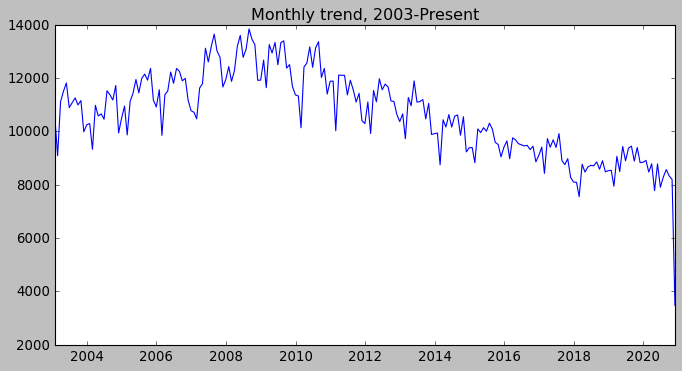

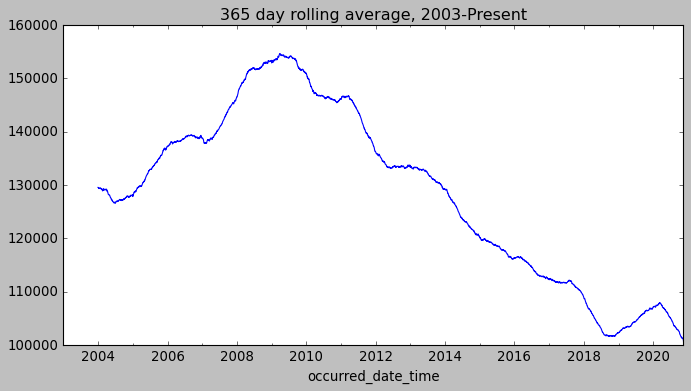

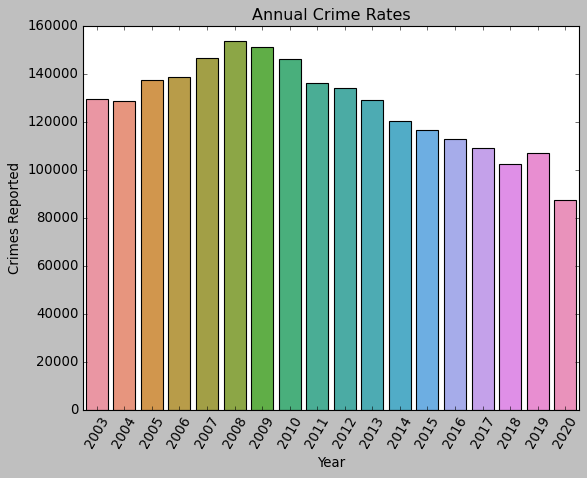

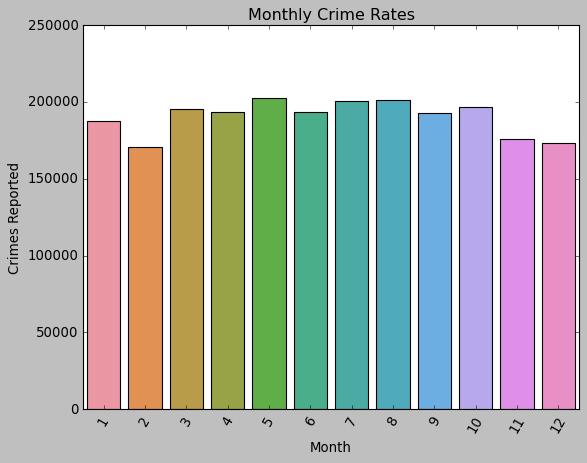

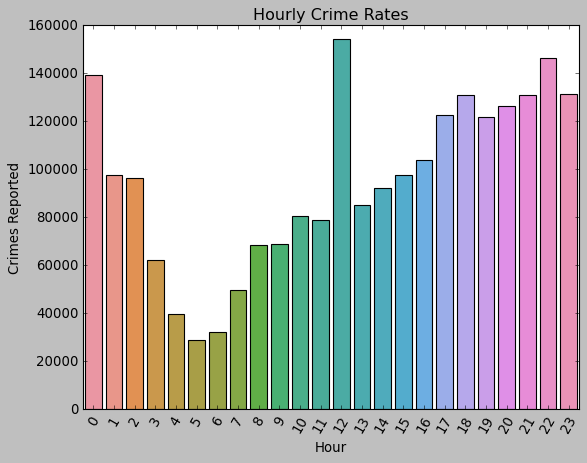

In [6]:
# plotting trend on a monthly basis

plt.figure(figsize=(10, 5))
plt.plot(df.resample("M").size())
plt.title("Monthly trend, 2003-Present")
plt.show()

# Above plot re-shown as rolling average

plt.figure(figsize=(10, 5))
df.resample("D").size().rolling(365).sum().plot()
plt.title("365 day rolling average, 2003-Present")
plt.show()


# Creating and visualizing a data frame for the overall yearly crime rate since 2003

crimes_per_year = df["year"].value_counts().sort_index()

#plt.figure(figsize=(8, 4))
g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(xlabel="Year", ylabel="Crimes Reported", title="Annual Crime Rates")
plt.show()

# Creating and visualizing a data frame for the overall yearly crime rate since 2003

crimes_per_month = df["month"].value_counts().sort_index()

#plt.figure(figsize=(8, 4))
d = sns.barplot(x=crimes_per_month.index, y=crimes_per_month.values)
d.set_xticklabels(d.get_xticklabels(), rotation=60)
d.set(xlabel="Month", ylabel="Crimes Reported", title="Monthly Crime Rates")
plt.show()

# Overall hourly crime rates as well

crimes_per_hour = df["hour"].value_counts().sort_index()

#plt.figure(figsize=(8, 4))
e = sns.barplot(x=crimes_per_hour.index, y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), rotation=60)
e.set(xlabel="Hour", ylabel="Crimes Reported", title="Hourly Crime Rates")
plt.show()

#### Top 50 crime types 

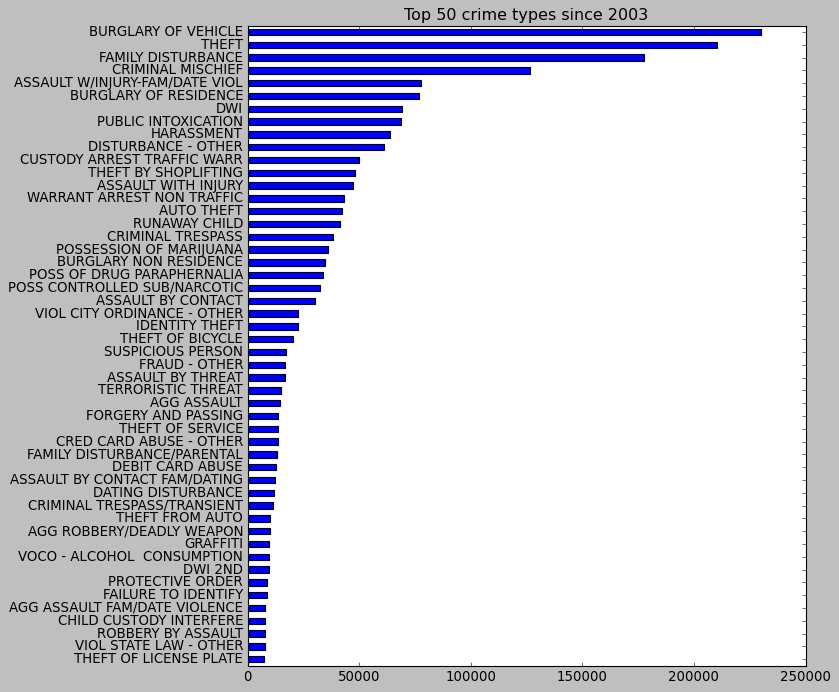

In [7]:
df.highest_offense_description.value_counts().head(50).sort_values().plot.barh(
    figsize=(9, 10), title="Top 50 crime types since 2003"
)

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    205448
78753.0    177528
78701.0    167626
78758.0    157891
78704.0    153601
78745.0    149785
78702.0    136123
78744.0    125419
78723.0    117534
78752.0     83919
78748.0     67539
78759.0     65762
78751.0     63669
78757.0     57385
78705.0     56685
78721.0     47428
78749.0     40156
78724.0     37415
78727.0     35579
78703.0     34972
78731.0     28429
78746.0     27967
78729.0     25338
78750.0     23481
78754.0     22556
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090466
78753.0    0.078172
78701.0    0.073811
78758.0    0.069525
78704.0    0.067636
78745.0    0.065955
78702.0    0.059940
78744.0    0.055226
78723.0    0.051754
78752.0    0.036952
78748.0    0.029740
78759.0    0.028957
78751.0    0.028036
78757.0    0.025269
78705.0    0.024960
78721.0    0.020884
78749.0    0.017682
78724.0    0.016475
78727.0    0.015667
78703.0    0.015399
78731.0    0.012518
78746.0    0.012315
78729.0    0.011157
78750.0    0.010339
78754.0    0.009932
Name: zip_code, dtype: float64

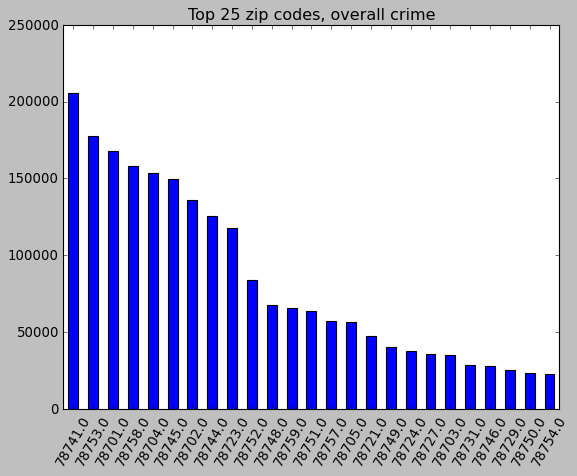

In [8]:
# Create and show dataframe for crime rates by zipcode and then as percentages

zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime

df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 zip codes, overall crime"
)
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.14%. This is a significant 1.29 percentage points higher than the number 2 area 78753 which hosts 7.85% of overall crime.

#### Taking a closer look at particular areas... 

The next section will examine the zip codes 78753, 78741, and 78745.

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             17042
BURGLARY OF VEHICLE               15884
FAMILY DISTURBANCE                14493
CRIMINAL MISCHIEF                  9360
THEFT BY SHOPLIFTING               7582
ASSAULT W/INJURY-FAM/DATE VIOL     7088
BURGLARY OF RESIDENCE              6031
DWI                                4933
DISTURBANCE - OTHER                4723
CUSTODY ARREST TRAFFIC WARR        4335
HARASSMENT                         4206
AUTO THEFT                         4136
POSS OF DRUG PARAPHERNALIA         3719
PUBLIC INTOXICATION                3361
ASSAULT WITH INJURY                3274
CRIMINAL TRESPASS                  3120
POSS CONTROLLED SUB/NARCOTIC       2957
RUNAWAY CHILD                      2914
WARRANT ARREST NON TRAFFIC         2789
POSSESSION OF MARIJUANA            2691
BURGLARY NON RESIDENCE             2468
VIOL CITY ORDINANCE - OTHER        1865
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.095996
BURGLARY OF VEHICLE               0.089473
FAMILY DISTURBANCE                0.081638
CRIMINAL MISCHIEF                 0.052724
THEFT BY SHOPLIFTING              0.042709
ASSAULT W/INJURY-FAM/DATE VIOL    0.039926
BURGLARY OF RESIDENCE             0.033972
DWI                               0.027787
DISTURBANCE - OTHER               0.026604
CUSTODY ARREST TRAFFIC WARR       0.024419
HARASSMENT                        0.023692
AUTO THEFT                        0.023298
POSS OF DRUG PARAPHERNALIA        0.020949
PUBLIC INTOXICATION               0.018932
ASSAULT WITH INJURY               0.018442
CRIMINAL TRESPASS                 0.017575
POSS CONTROLLED SUB/NARCOTIC      0.016657
RUNAWAY CHILD                     0.016414
WARRANT ARREST NON TRAFFIC        0.015710
POSSESSION OF MARIJUANA           0.015158
BURGLARY NON RESIDENCE            0.013902
VIOL CITY ORDINANCE - OTHER       0.010505
Name: highest_offense_description, dtype: float64

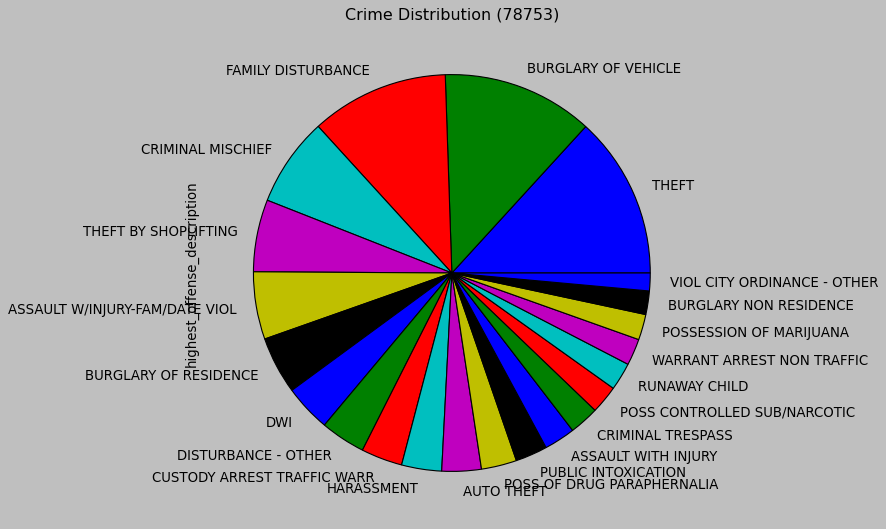

In [9]:
# Examining crime in the 78753 area

df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode

df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages

display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20177
BURGLARY OF VEHICLE               19735
THEFT                             15497
CRIMINAL MISCHIEF                 10969
ASSAULT W/INJURY-FAM/DATE VIOL     9580
BURGLARY OF RESIDENCE              8842
PUBLIC INTOXICATION                6368
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5625
HARASSMENT                         5456
DISTURBANCE - OTHER                5130
AUTO THEFT                         4560
ASSAULT WITH INJURY                4513
CRIMINAL TRESPASS                  3884
POSS CONTROLLED SUB/NARCOTIC       3834
POSSESSION OF MARIJUANA            3790
THEFT BY SHOPLIFTING               3566
POSS OF DRUG PARAPHERNALIA         3525
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2779
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098210
BURGLARY OF VEHICLE               0.096058
THEFT                             0.075430
CRIMINAL MISCHIEF                 0.053391
ASSAULT W/INJURY-FAM/DATE VIOL    0.046630
BURGLARY OF RESIDENCE             0.043038
PUBLIC INTOXICATION               0.030996
CUSTODY ARREST TRAFFIC WARR       0.029258
DWI                               0.027379
HARASSMENT                        0.026557
DISTURBANCE - OTHER               0.024970
AUTO THEFT                        0.022195
ASSAULT WITH INJURY               0.021967
CRIMINAL TRESPASS                 0.018905
POSS CONTROLLED SUB/NARCOTIC      0.018662
POSSESSION OF MARIJUANA           0.018447
THEFT BY SHOPLIFTING              0.017357
POSS OF DRUG PARAPHERNALIA        0.017158
WARRANT ARREST NON TRAFFIC        0.016783
RUNAWAY CHILD                     0.013527
VIOL CITY ORDINANCE - OTHER       0.010689
Name: highest_offense_description, dtype: float64

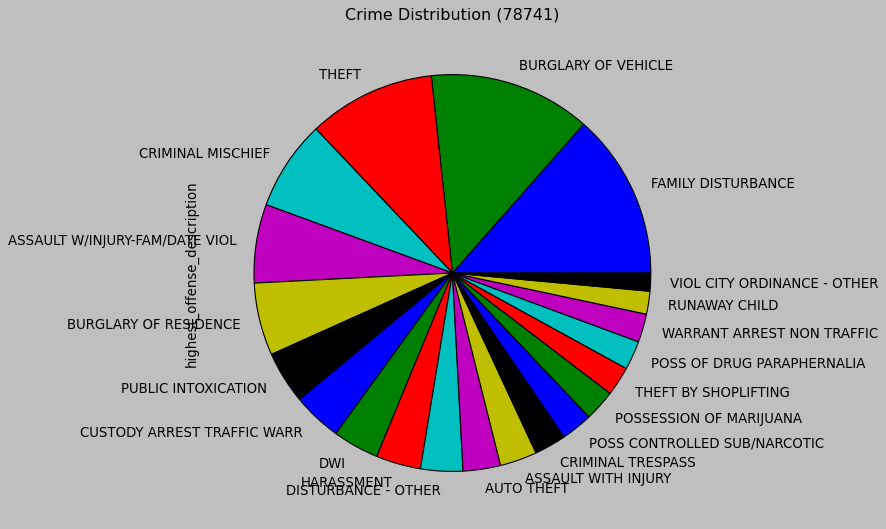

In [10]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)

df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode

df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages

display(df_41_off)
print("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78745?

FAMILY DISTURBANCE                14786
BURGLARY OF VEHICLE               14713
THEFT                             13471
CRIMINAL MISCHIEF                  8446
BURGLARY OF RESIDENCE              5852
ASSAULT W/INJURY-FAM/DATE VIOL     5718
HARASSMENT                         5104
DISTURBANCE - OTHER                4483
DWI                                4394
PUBLIC INTOXICATION                3988
CUSTODY ARREST TRAFFIC WARR        3244
BURGLARY NON RESIDENCE             2910
AUTO THEFT                         2812
ASSAULT WITH INJURY                2641
RUNAWAY CHILD                      2589
POSSESSION OF MARIJUANA            2584
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2010
THEFT BY SHOPLIFTING               1959
CRIMINAL TRESPASS                  1936
IDENTITY THEFT                     1553
POSS OF DRUG PARAPHERNALIA         1511
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098715
BURGLARY OF VEHICLE               0.098227
THEFT                             0.089936
CRIMINAL MISCHIEF                 0.056387
BURGLARY OF RESIDENCE             0.039069
ASSAULT W/INJURY-FAM/DATE VIOL    0.038175
HARASSMENT                        0.034076
DISTURBANCE - OTHER               0.029930
DWI                               0.029335
PUBLIC INTOXICATION               0.026625
CUSTODY ARREST TRAFFIC WARR       0.021658
BURGLARY NON RESIDENCE            0.019428
AUTO THEFT                        0.018774
ASSAULT WITH INJURY               0.017632
RUNAWAY CHILD                     0.017285
POSSESSION OF MARIJUANA           0.017251
WARRANT ARREST NON TRAFFIC        0.014074
POSS CONTROLLED SUB/NARCOTIC      0.013419
THEFT BY SHOPLIFTING              0.013079
CRIMINAL TRESPASS                 0.012925
IDENTITY THEFT                    0.010368
POSS OF DRUG PARAPHERNALIA        0.010088
Name: highest_offense_description, dtype: float64

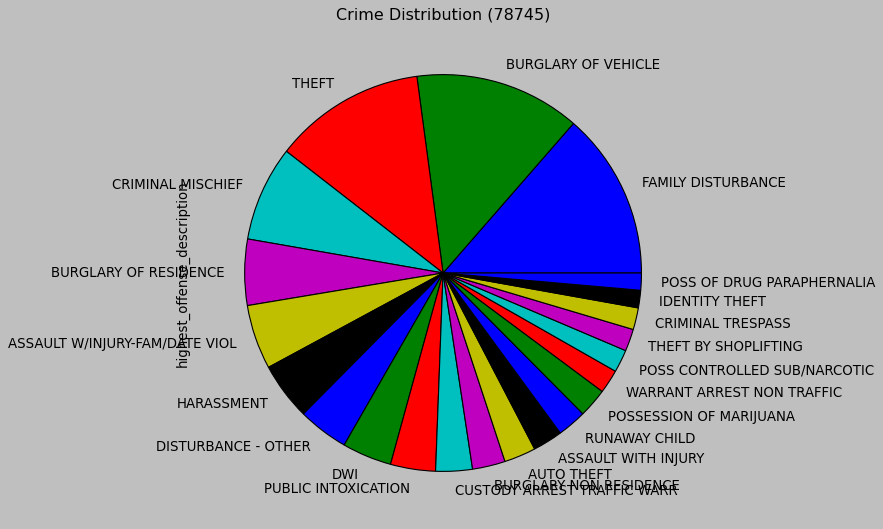

In [11]:
# Examining crime in the 78745 area

df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode

df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages

display(df_45_off)
print("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))

df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q5'></a>
### E. Question 5. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

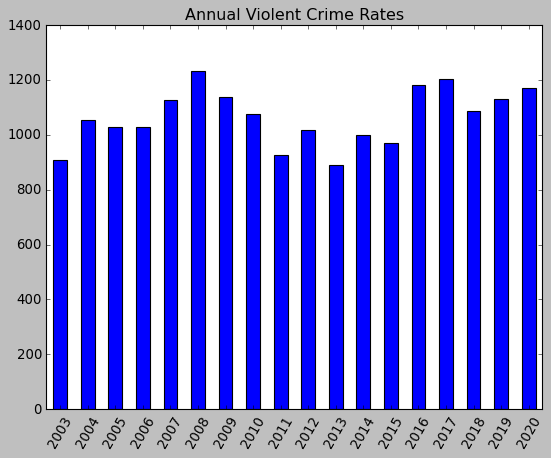

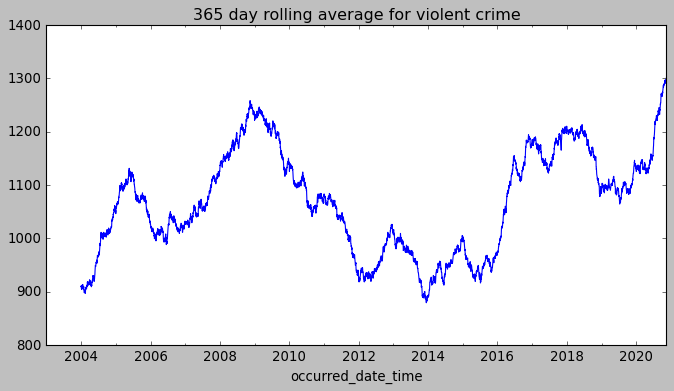

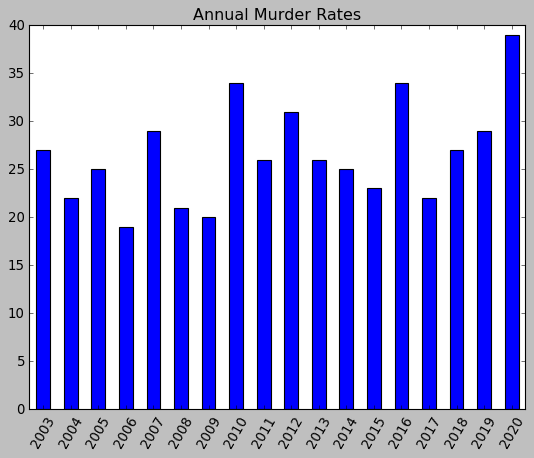

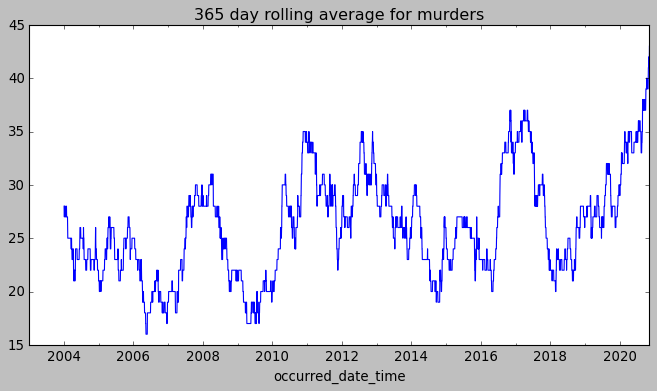

78741.0    0.114725
78701.0    0.097884
78753.0    0.092727
78758.0    0.083044
78702.0    0.074361
78723.0    0.067098
78745.0    0.059467
78744.0    0.054047
78704.0    0.050837
78752.0    0.046364
78721.0    0.031470
78724.0    0.027787
78705.0    0.025524
78757.0    0.019577
78748.0    0.018735
78751.0    0.017261
78759.0    0.012999
78749.0    0.008736
78617.0    0.008525
78722.0    0.008262
78754.0    0.008157
78727.0    0.007841
78729.0    0.007631
78750.0    0.005578
78731.0    0.005473
Name: zip_code, dtype: float64

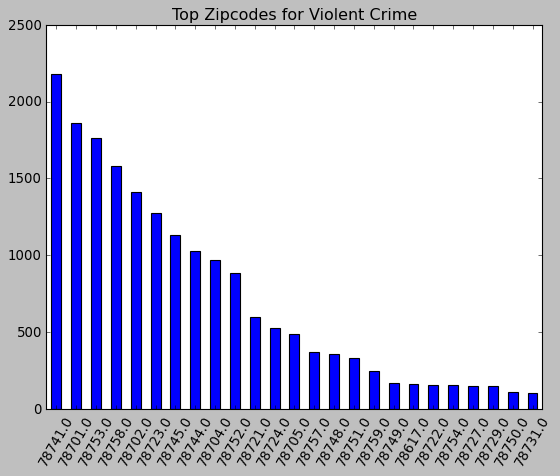

78753.0    0.110879
78741.0    0.106695
78723.0    0.094142
78758.0    0.092050
78744.0    0.069038
78702.0    0.058577
78745.0    0.058577
78752.0    0.056485
78701.0    0.039749
78704.0    0.037657
78721.0    0.033473
78724.0    0.029289
78749.0    0.023013
78751.0    0.016736
78705.0    0.016736
78757.0    0.016736
78727.0    0.014644
78748.0    0.014644
78754.0    0.014644
78759.0    0.014644
78617.0    0.012552
78731.0    0.010460
78750.0    0.008368
78747.0    0.008368
78735.0    0.006276
Name: zip_code, dtype: float64

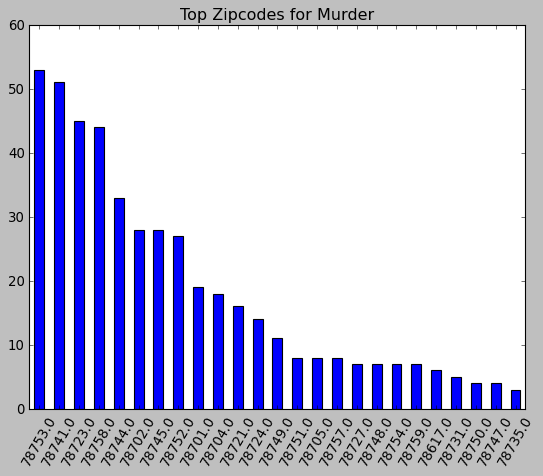

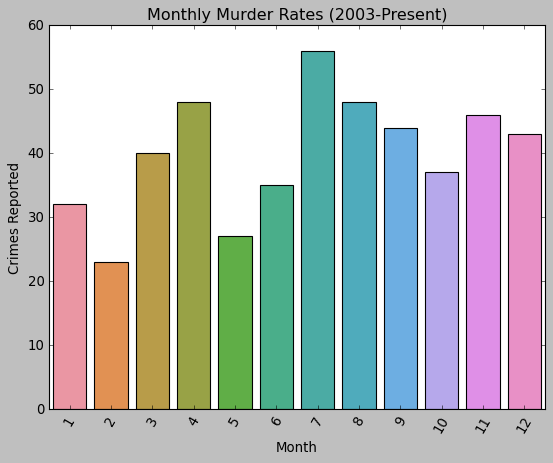

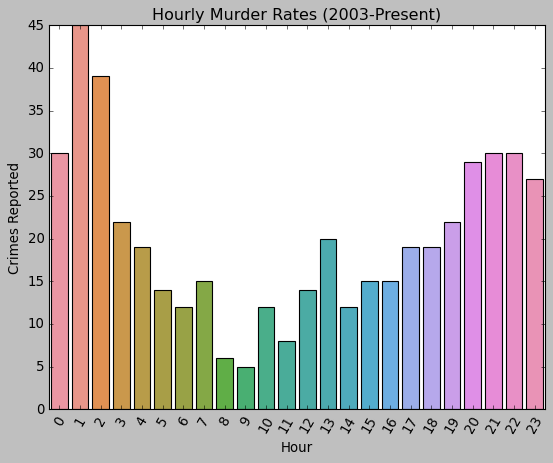

highest_offense_description  AGG ASSAULT  CAPITAL MURDER  MURDER  RAPE
zip_code                                                              
78610.0                                1               0       0     0
78613.0                               14               0       1     6
78617.0                              120               0       6    36
78621.0                                1               0       0     0
78634.0                                1               0       0     0
78652.0                                2               0       0     0
78653.0                               10               0       1     1
78660.0                               66               0       2    17
78664.0                                3               0       0     0
78681.0                                1               0       0     1
78701.0                             1484               1      18   357
78702.0                             1199               3      25   186
78703.0                               55               1       0    36
78704.0                              704               2      16   244
78705.0                              266               2       6   211
78712.0                                1               0       0     1
78717.0                               36               0       1    13
78719.0                               10               0       0     1
78721.0                              509               3      13    73
78722.0                              116               1       0    40
78723.0                             1033              11      34   197
78724.0                              448               2      12    66
78725.0                               22               0       0    11
78726.0                               34               0       1    36
78727.0                               99               2       5    43
78728.0                                7               0       1     4
78729.0                               87               0       2    56
78730.0                               13               0       0     8
78731.0                               47               1       4    52
78732.0                                1               0       0     1
78733.0                                1               0       0     0
78735.0                               84               0       3    11
78736.0                               20               0       0    10
78737.0                                2               0       0     2
78738.0                                1               0       0     0
78739.0                                7               0       0     5
78741.0                             1624               7      44   505
78742.0                               36               0       2     8
78744.0                              785               4      29   209
78745.0                              822               6      22   280
78746.0                               39               0       2    29
78747.0                               55               0       4    27
78748.0                              236               3       4   113
78749.0                              100               1      10    55
78750.0                               71               0       4    31
78751.0                              209               0       8   111
78752.0                              714               6      21   140
78753.0                             1346              12      41   363
78754.0                              100               2       5    48
78756.0                               62               0       2    38
78757.0                              283               2       6    81
78758.0                             1220               8      36   314
78759.0                              132               1       6   108

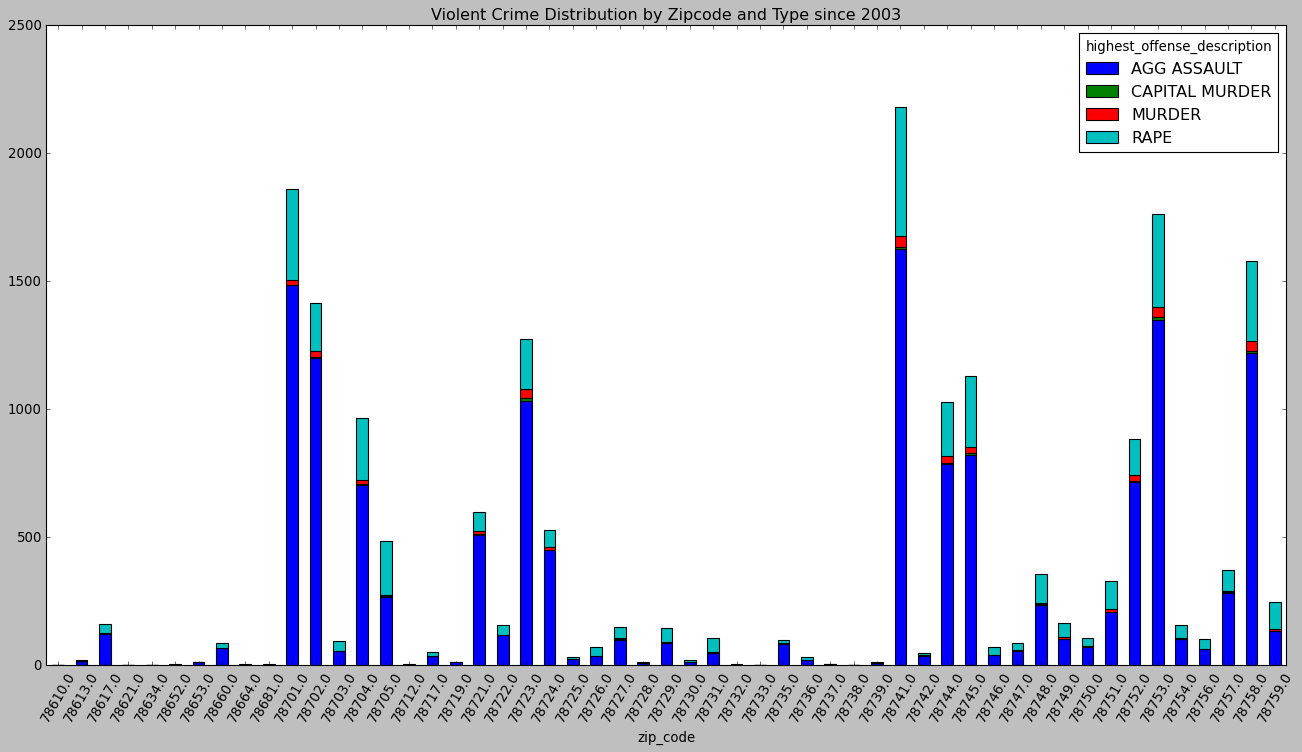

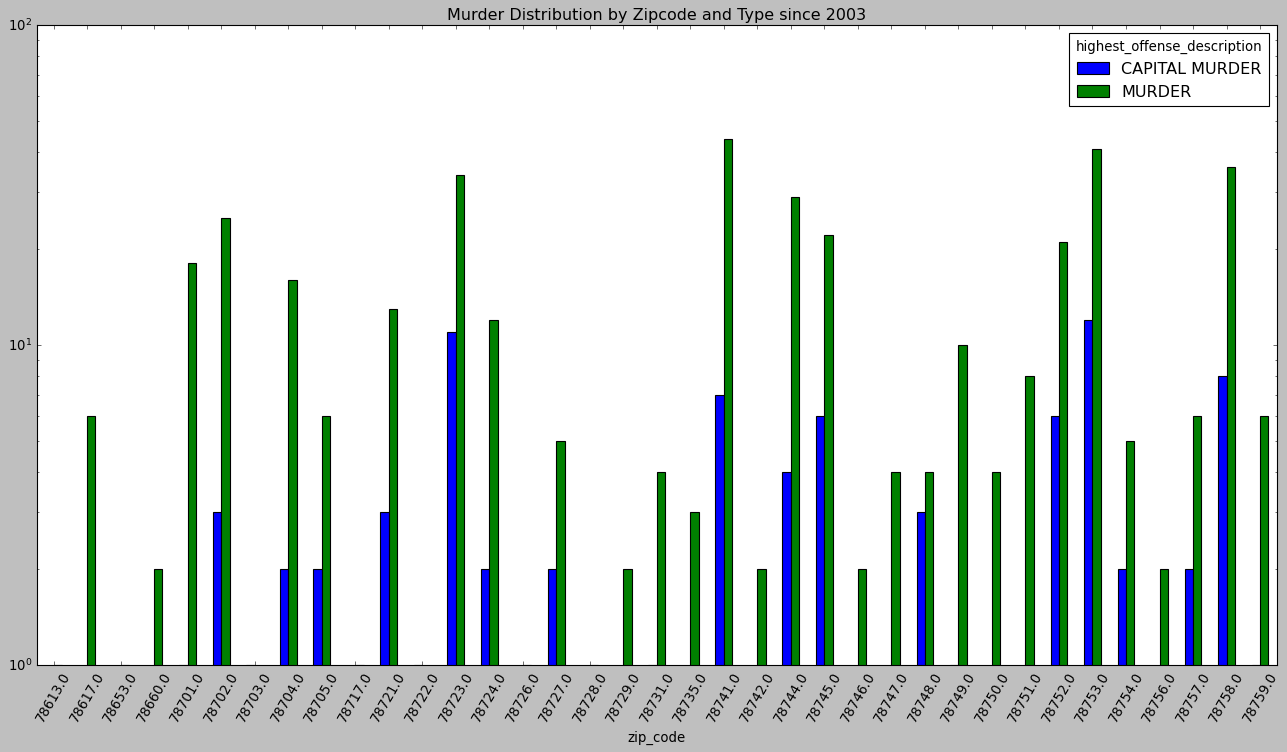

In [12]:
# Creating an overall and separate dataframes for violent crime

df_viol = df.query(
    'highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == "MURDER"]
df_mur_cap = df[df.highest_offense_description == "CAPITAL MURDER"]
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_rape = df[df.highest_offense_description == "RAPE"]

# Visualizing violent crimes per year

viol_per_year = df_viol["year"].value_counts().sort_index()
viol_per_year.plot.bar(rot=60, title="Annual Violent Crime Rates", fontsize=12)
plt.show()

# As rolling average

plt.figure(figsize=(10, 5))
df_viol.resample("D").size().rolling(365).sum().plot()
plt.title("365 day rolling average for violent crime")
plt.show()

# Visualizing murders per year

viol_mur_per_year = df_viol_mur.year.value_counts().sort_index()
viol_mur_per_year.plot.bar(rot=60, title="Annual Murder Rates", fontsize=12)
plt.show()

# As rolling average

plt.figure(figsize=(10, 5))
df_viol_mur.resample("D").size().rolling(365).sum().plot()
plt.title("365 day rolling average for murders")
plt.show()

# Violent Crime by Zipcode

display(df_viol.zip_code.value_counts(normalize=True).head(25))
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top Zipcodes for Violent Crime", fontsize=12, rot=60
)
plt.show()

# Murder by Zipcode

display(df_viol_mur.zip_code.value_counts(normalize=True).head(25))
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    fontsize=12, title="Top Zipcodes for Murder", rot=60
)
plt.show()

mur_by_month = df_viol_mur["month"].value_counts().sort_index()
mur_by_hour = df_viol_mur["hour"].value_counts().sort_index()

# Visualizing monthly & hourly murder rate with Seaborn

v = sns.barplot(x=mur_by_month.index, y=mur_by_month.values)
v.set_xticklabels(v.get_xticklabels(), rotation=60)
v.set(
    xlabel="Month",
    ylabel="Crimes Reported",
    title="Monthly Murder Rates (2003-Present)",
)
plt.show()

# Hourly rate with Seaborn

f = sns.barplot(x=mur_by_hour.index, y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), rotation=60)
f.set(
    xlabel="Hour",
    ylabel="Crimes Reported",
    title="Hourly Murder Rates (2003-Present)",
)
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(
    figsize=(20, 10),
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    fontsize=12,
    stacked=True,
    rot=60,
)
plt.show()

viol_mur_freq = pd.crosstab(
    df_viol_mur.zip_code, df_viol_mur.highest_offense_description
)

viol_mur_freq.plot.bar(
    figsize=(20, 10),
    title="Murder Distribution by Zipcode and Type since 2003",
    fontsize=12,
    logy=True,
    rot=60,
)
plt.show()

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, as of 10/19/2020, murders already totaled 34--the same amount for 2016 and 2010!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How is crime distributed across council districts and APD sectors?

#### checking council districts and APD sectors for overall crime rates 

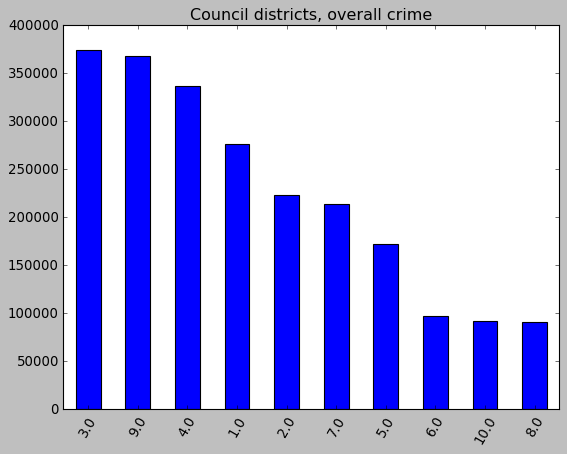

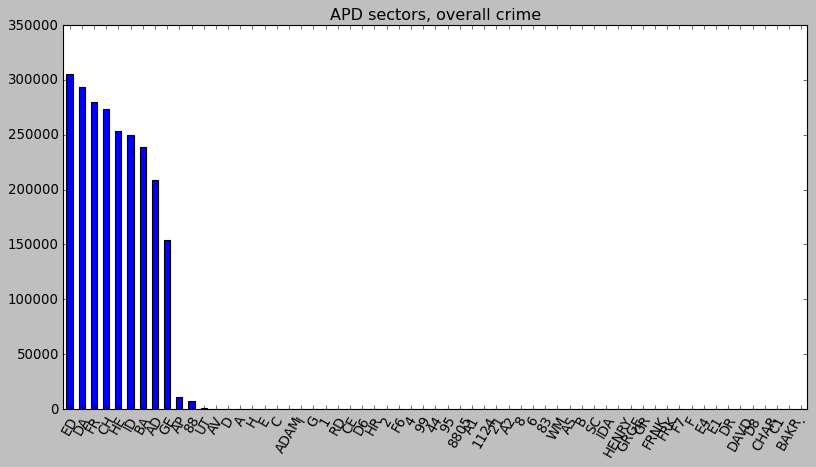

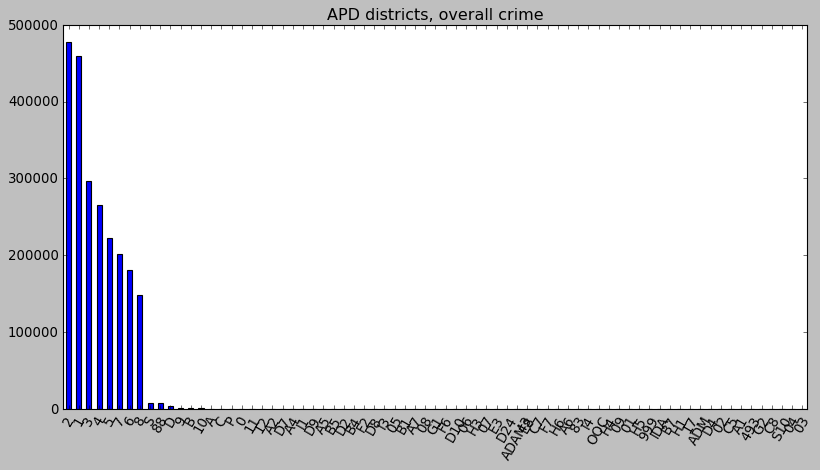

In [13]:
df.council_district.value_counts().plot.bar(
    title="Council districts, overall crime", rot=60
)
plt.show()

df.apd_sector.value_counts().plot.bar(
    title="APD sectors, overall crime",
    figsize=(12, 6),
    rot=60,
)
plt.show()

df.apd_district.value_counts().plot.bar(
    title="APD districts, overall crime", rot=60, figsize=(12, 6)
)
plt.show()

#### Distribution of violent crime and murders across council districts and APD sectors 

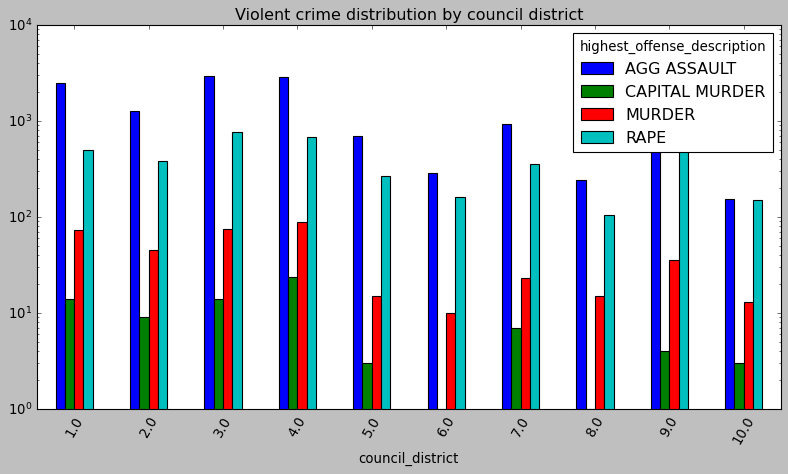

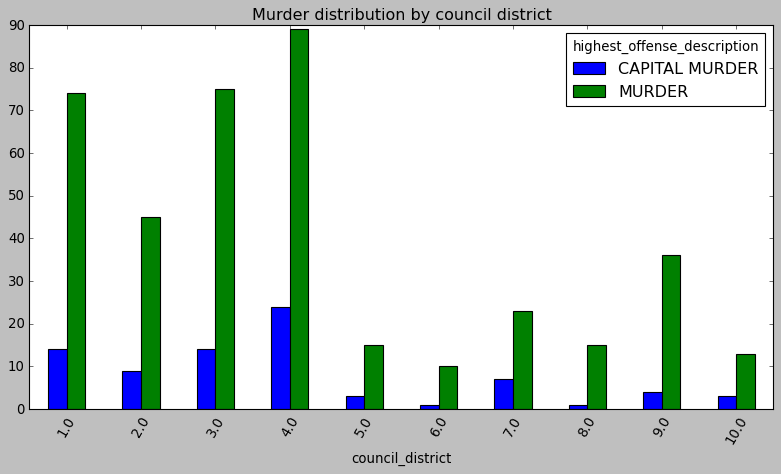

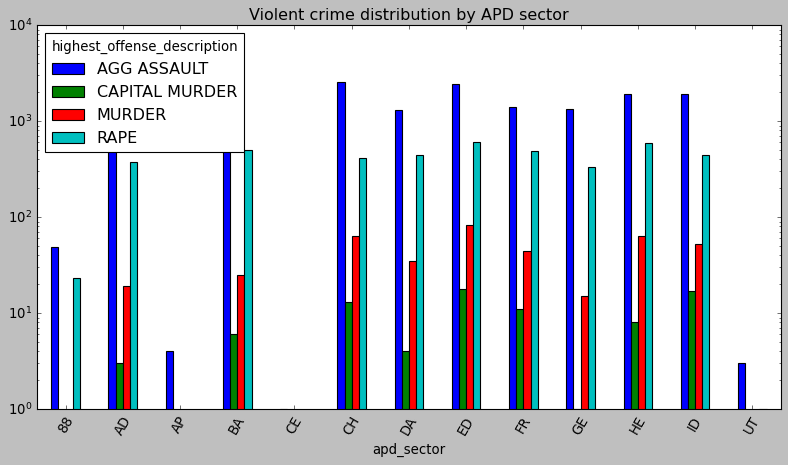

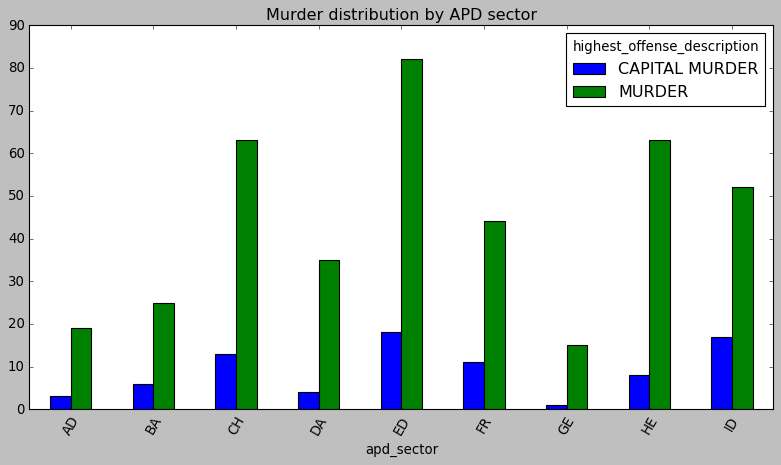

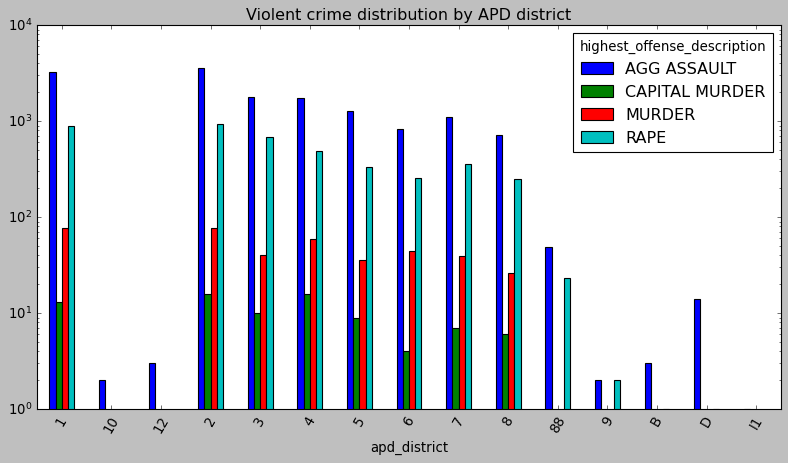

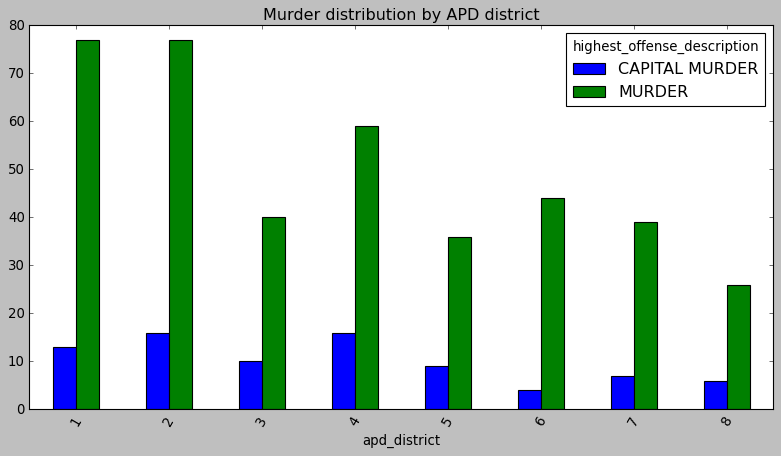

In [14]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6),
    logy=True,
    rot=60,
    title="Violent crime distribution by council district",
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(figsize=(12, 6), rot=60, title="Murder distribution by council district")
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), logy=True, rot=60, title="Violent crime distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6),
    rot=60,
    logy=True,
    title="Violent crime distribution by APD district",
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD district"
)
plt.show()

<a id='q7'></a>
### G. Question 7. How does murder appear on the map? 

In [15]:
# As a heatmap

mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=11)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="aus_mur_heatmap.html")

k

In [16]:
# Pinpointing individual addresses

mur_coords_add = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

m = folium.Map([30.2672, -97.7431], tiles="OpenStreetMap", zoom_level=11)

for (index, row) in mur_coords_add.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    name = row["address"]
    folium.Marker([lat, lon], popup=name).add_to(m)

m.save(outfile="aus_mur_map.html")

m

#### Are there any addresses where murder occurs frequently?

In [17]:
df_viol_mur.address.value_counts().head(31)

6409 SPRINGDALE RD           3
8800 N IH 35 SVRD SB         3
4700 E RIVERSIDE DR          3
6407 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
9200 NORTH PLZ               2
6600 ED BLUESTEIN BLVD SB    2
1711 RUTLAND DR              2
9220 N IH 35 SVRD SB         2
8912 N LAMAR BLVD            2
8225 SAM RAYBURN DR          2
2501 ANKEN DR                2
2400 WICKERSHAM LN           2
10610 MORADO CIR             2
2508 E RIVERSIDE DR          2
605 MASTERSON PASS           2
1050 SPRINGDALE RD           2
10503 N LAMAR BLVD           2
9601 MIDDLE FISKVILLE RD     2
201 W 5TH ST                 2
2101 ELMONT DR               2
9010 GALEWOOD DR             2
833 FAIRFIELD DR             2
2713 S CONGRESS AVE          2
815 W SLAUGHTER LN           2
744 W WILLIAM CANNON DR      2
6118 FAIRWAY ST              2
1137 GUNTER ST               2
2915 S IH 35 SVRD NB         2
601 E 15TH ST                2
7000 DECKER LN               2
Name: address, dtype: int64

## IV. Prediction Modeling 

### Time Series Modeling of the overall dataframe with Facebook Prophet 

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


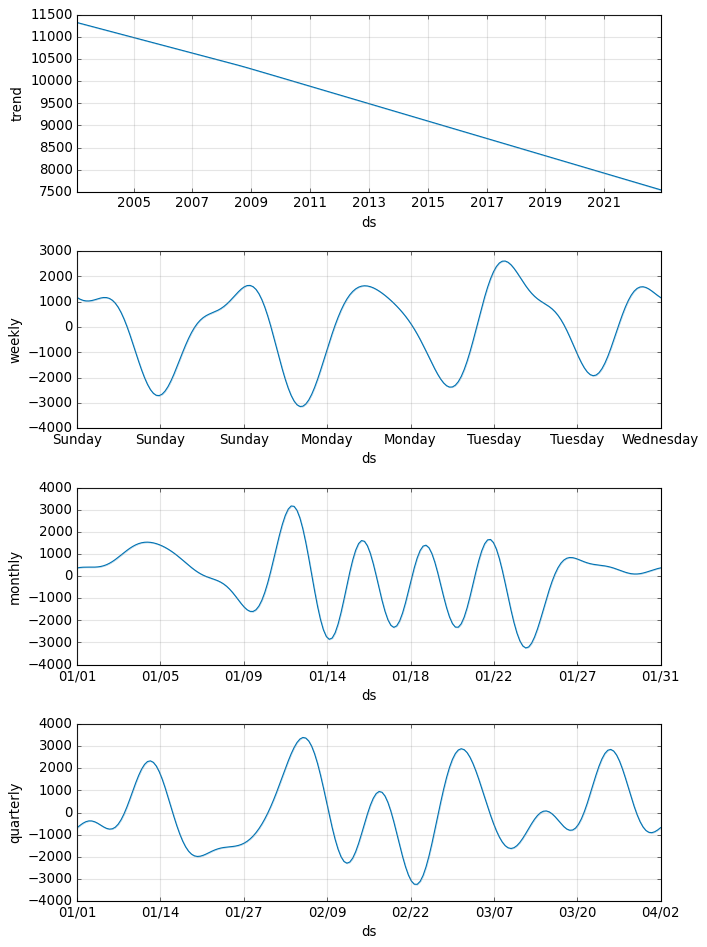

In [23]:
df_fbprophet = df

df_m_1 = df_fbprophet.resample("M").size().reset_index()
df_m_1.columns = ["date", "monthly_crime_count"]
df_m_final_1 = df_m_1.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_1 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_1.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_1.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_1.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_1.fit(df_m_final_1)

future_1 = m_1.make_future_dataframe(periods=24, freq="M")
pred_1 = m_1.predict(future_1)
fig2_1 = m_1.plot_components(pred_1)
fig2_2 = plot_plotly(m_1, pred_1)
fig2_2

### ...now the violent crime dataframe

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


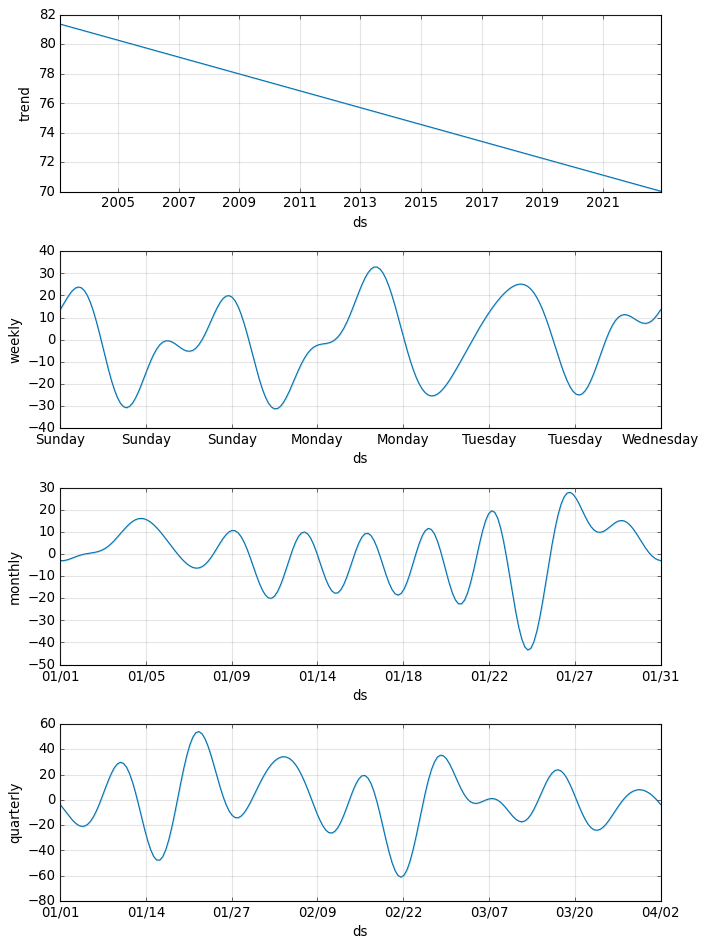

In [24]:
df_viol_fbprophet = df_viol

df_v = df_viol_fbprophet.resample("M").size().reset_index()
df_v.columns = ["date", "monthly_crime_count"]
df_v_final = df_v.rename(columns={"date": "ds", "monthly_crime_count": "y"})

v = Prophet(interval_width=0.95, yearly_seasonality=False)
v.add_seasonality(name="monthly", period=30.5, fourier_order=10)
v.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
v.add_seasonality(name="weekly", period=52.25, fourier_order=10)
v.fit(df_v_final)

future = v.make_future_dataframe(periods=24, freq="M")
pred = v.predict(future)
fig2_1 = v.plot_components(pred)
fig2_3 = plot_plotly(v, pred)
fig2_3

### ...now the murder dataframe 

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


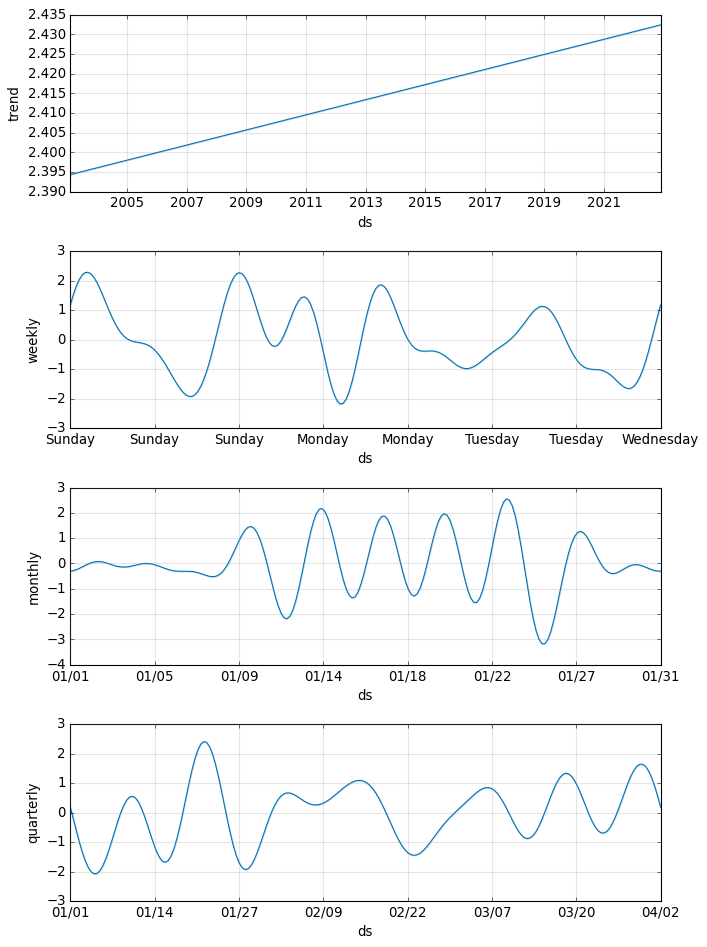

In [25]:
df_viol_mur_fbprophet = df_viol_mur

df_m = df_viol_mur_fbprophet.resample("M").size().reset_index()
df_m.columns = ["date", "monthly_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m = Prophet(interval_width=0.95, yearly_seasonality=False)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=24, freq="M")

pred = m.predict(future)
fig3_1 = m.plot_components(pred)
fig3_3 = plot_plotly(m, pred)
fig3_3

### ...now examining some zip codes

#### 78753

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


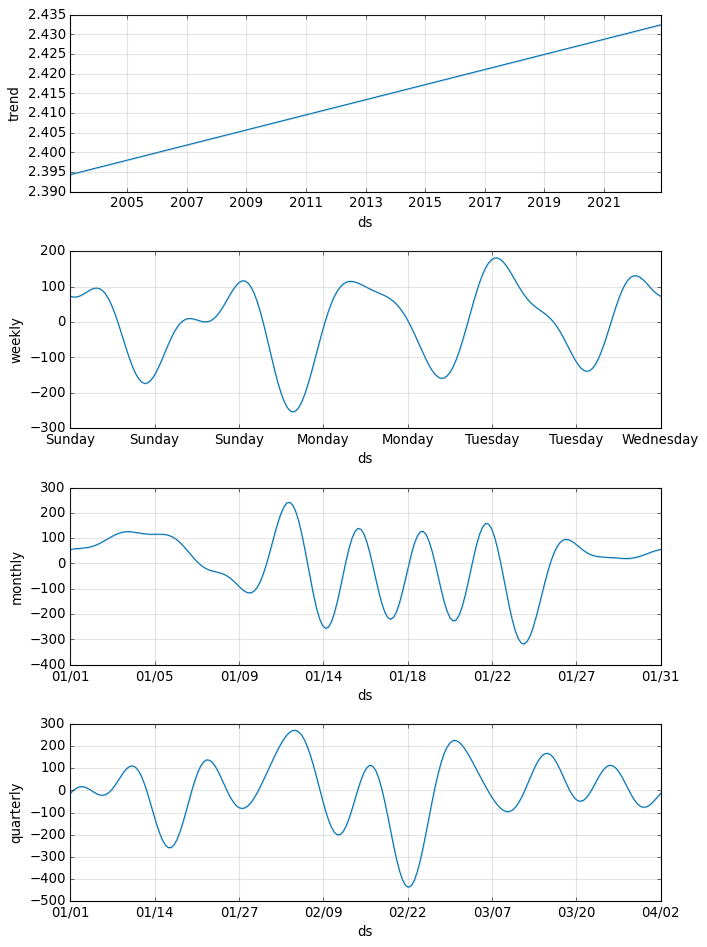

In [26]:
df_fbprophet_53 = df_53

df_m_53 = df_fbprophet_53.resample("M").size().reset_index()
df_m_53.columns = ["date", "monthly_crime_count"]
df_m_final_53 = df_m_53.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_53 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_53.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_53.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_53.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_53.fit(df_m_final_53)

future_53 = m_53.make_future_dataframe(periods=24, freq="M")
pred_53 = m_53.predict(future)
fig2_53 = m_53.plot_components(pred)
fig2_53_1 = plot_plotly(m_53, pred_53)
fig2_53_1

#### 78741

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


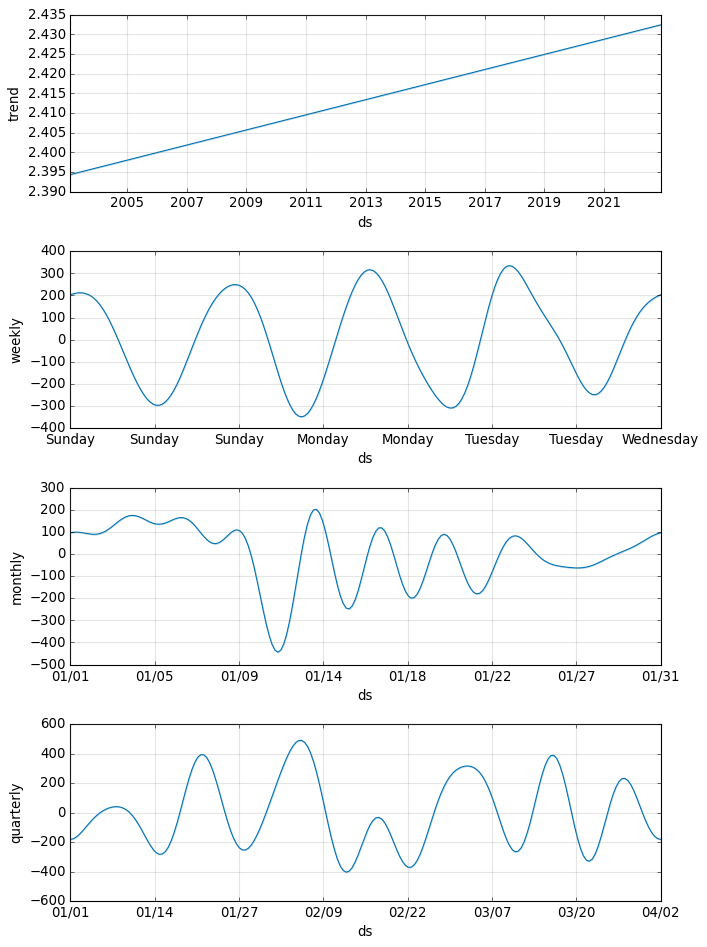

In [27]:
df_fbprophet_41 = df_41

df_m_41 = df_fbprophet_41.resample("M").size().reset_index()
df_m_41.columns = ["date", "monthly_crime_count"]
df_m_final_41 = df_m_41.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_41 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_41.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_41.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_41.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_41.fit(df_m_final_41)

future_41 = m_41.make_future_dataframe(periods=24, freq="M")
pred_41 = m_41.predict(future)
fig2_41 = m_41.plot_components(pred)
fig2_41_1 = plot_plotly(m_41, pred_53)
fig2_41_1

#### 78745

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


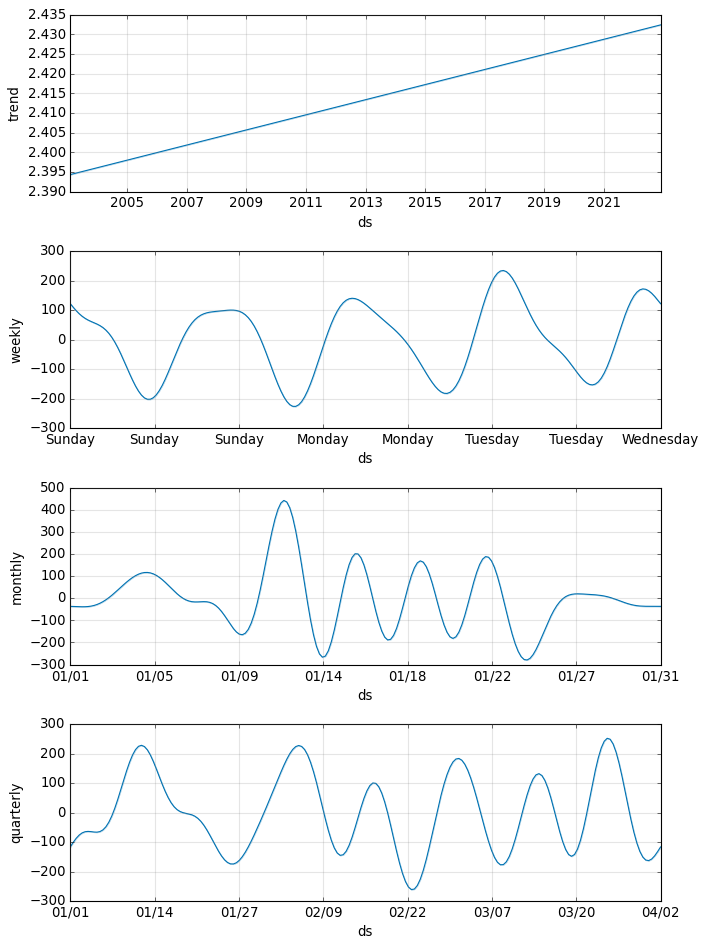

In [28]:
df_fbprophet_45 = df_45

df_m_45 = df_fbprophet_45.resample("M").size().reset_index()
df_m_45.columns = ["date", "monthly_crime_count"]
df_m_final_45 = df_m_45.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_45 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_45.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_45.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_45.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_45.fit(df_m_final_45)

future_45 = m_45.make_future_dataframe(periods=24, freq="M")
pred_45 = m_45.predict(future)
fig2_45 = m_45.plot_components(pred)
fig2_45_1 = plot_plotly(m_45, pred_45)
fig2_45_1